# Tidy loaneR

I haven't used R for a long and decided to write a short script which is based on the idea of [tidymodels](https://www.tidymodels.org/). Usually I prefer more low-level coding, but tidy approach seems quite nice.

In [1]:
library(tidyverse)
library(workflows)
library(yardstick)
library(rsample)
library(recipes)
library(bonsai)
library(dials)
library(tune)
library(vip)

set.seed(0)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'yardstick'


The following object is masked from 'package:readr':

    spec



Attaching package: 'recipes'


The following object is masked from 'package:stringr':

    fixed


The following object is masked from 'package:stats':

    step


Loading required package: parsnip

Loading required package: scales


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package

## Loading and splitting

In [2]:
train <- read_csv("../input/playground-series-s4e10/train.csv") |> 
    mutate(loan_status = as_factor(loan_status))
test <- read_csv("../input/playground-series-s4e10/test.csv") 

Rows: 58645 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): person_home_ownership, loan_intent, loan_grade, cb_person_default_o...
dbl (9): id, person_age, person_income, person_emp_length, loan_amnt, loan_i...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 39098 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): person_home_ownership, loan_intent, loan_grade, cb_person_default_o...
dbl (8): id, person_age, person_income, person_emp_length, loan_amnt, loan_i...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
glimpse(train)

Rows: 58,645
Columns: 13
$ id                         <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…
$ person_age                 <dbl> 37, 22, 29, 30, 22, 27, 25, 21, 37, 35, 30,…
$ person_income              <dbl> 35000, 56000, 28800, 70000, 60000, 45000, 4…
$ person_home_ownership      <chr> "RENT", "OWN", "OWN", "RENT", "RENT", "RENT…
$ person_emp_length          <dbl> 0, 6, 8, 14, 2, 2, 9, 0, 11, 0, 5, 6, 1, 2,…
$ loan_intent                <chr> "EDUCATION", "MEDICAL", "PERSONAL", "VENTUR…
$ loan_grade                 <chr> "B", "C", "A", "B", "A", "A", "A", "C", "D"…
$ loan_amnt                  <dbl> 6000, 4000, 6000, 12000, 6000, 9000, 12000,…
$ loan_int_rate              <dbl> 11.49, 13.35, 8.90, 11.11, 6.92, 8.94, 6.54…
$ loan_percent_income        <dbl> 0.17, 0.07, 0.21, 0.17, 0.10, 0.20, 0.27, 0…
$ cb_person_default_on_file  <chr> "N", "N", "N", "N", "N", "N", "N", "Y", "Y"…
$ cb_person_cred_hist_length <dbl> 14, 2, 10, 5, 3, 5, 3, 3, 11, 6, 5, 2, 3, 9…
$ loan_status  

In [4]:
sum(is.na(train))

[1] 0

In [5]:
cats <- c("person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file")
drop <- c("id", "person_age")

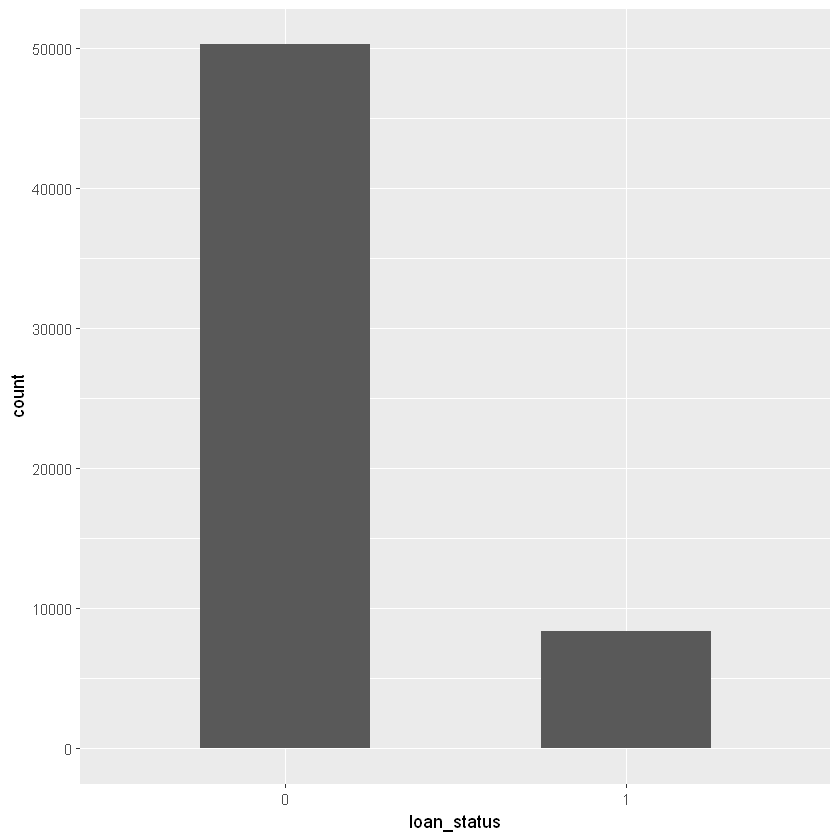

In [6]:
ggplot(train, aes(loan_status)) +
geom_bar(width = 0.5)

There are no missing values. The dataset contains 4 categorical features. The target variable *loan_status* is binary. We can observe severe imbalance here.

Let's create an initial split with 85% for training purposes. The rest we'll use to estimate performance of the final model. Also we'll create 5 folds stratified by *loan_status*


In [15]:
set.seed(1234)
splits <- initial_split(train, prop = 0.85, strata = loan_status)
tr <- training(splits)
te <- testing(splits) 
folds <- vfold_cv(tr, v = 5, strata = loan_status)

In [17]:
tr |> filter(loan_status=='1')|>summarise(sum(id))

sum(id)
<dbl>
206421843


## Model workflow

We specify a recipe for data transformation, which includes dropping of variables, normalizing, and converting strings to integers. Also we set an engine for a model.

In [18]:
rec <- recipe(loan_status ~ ., data = tr) |>
  step_rm(all_of(drop)) |> 
  step_normalize(all_numeric_predictors()) |> 
  step_integer(all_nominal_predictors()) 

mod <- boost_tree(learn_rate = 0.05,
                  trees = tune(),
                  tree_depth = tune(), 
                  sample_size = tune()) |> 
  set_engine(engine = "xgboost", 
             lambda = 0.15,
             nthread = parallel::detectCores()) |>
  set_mode(mode = "classification")

wflow <- workflow(rec, mod)

In [22]:
tmp|>summarize(sum(loan_amnt),sum(person_income))

sum(loan_amnt),sum(person_income)
<dbl>,<dbl>
5.566596e-12,7.36973e-13


## Tuning model using resamples

In [ ]:
set.seed(1234)
ctrl <- control_resamples(save_pred = TRUE, save_workflow = TRUE)
grid <- grid_random(trees(range = c(1000, 2000)),
                    tree_depth(range = c(4, 6)), 
                    sample_prop(range = c(0.6, 0.8)),
                    size = 30)
tune_res <- tune_grid(wflow, 
                      resamples = folds,
                      grid = grid,
                      control = ctrl,
                      metrics = metric_set(roc_auc))

tune_res %>% 
  collect_metrics() %>% 
  ggplot(aes(x = sample_size, y = mean, color = as_factor(tree_depth))) + 
  geom_point() + 
  labs(x = "Sample_size", y = "AUC", color = "Tree depth") +
  theme_bw()

## The best model. ROC curve

trees,tree_depth,sample_size,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1332,4,0.7999837,roc_auc,binary,0.9572484,5,0.001614907,Preprocessor1_Model12
1210,4,0.7552889,roc_auc,binary,0.9571345,5,0.001668334,Preprocessor1_Model09
1005,4,0.6561501,roc_auc,binary,0.9569485,5,0.001576281,Preprocessor1_Model02
1461,4,0.7581465,roc_auc,binary,0.9569244,5,0.001462369,Preprocessor1_Model10
1485,4,0.7875988,roc_auc,binary,0.9567294,5,0.001393353,Preprocessor1_Model11


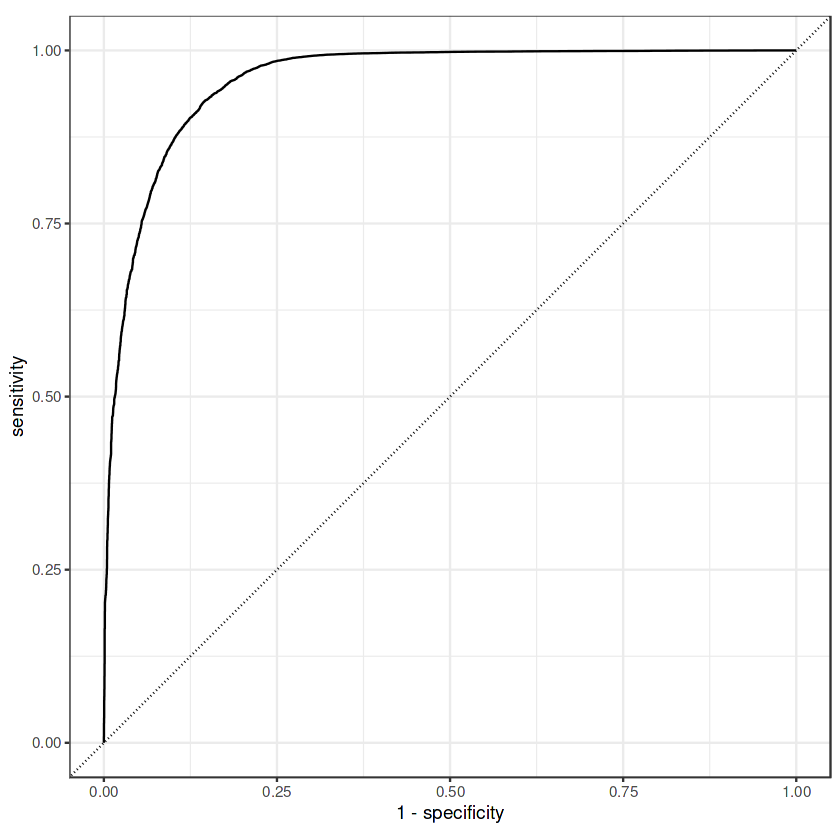

In [ ]:
show_best(tune_res, metric="roc_auc")
best_par <- select_best(tune_res, metric="roc_auc")

collect_predictions(tune_res, parameters = best_par) |> 
  roc_curve(loan_status, .pred_0) |> 
  autoplot()

## Final model

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.95362582,Preprocessor1_Model1
roc_auc,binary,0.96383566,Preprocessor1_Model1
brier_class,binary,0.03728938,Preprocessor1_Model1


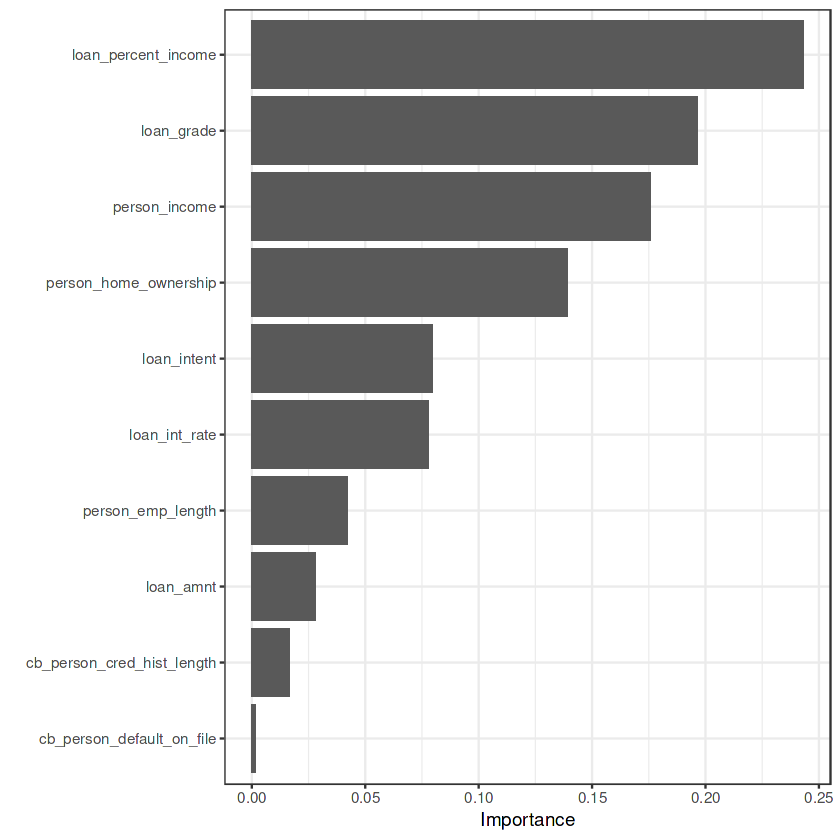

In [ ]:
final_wflow <- finalize_workflow(wflow, best_par)
final_fit <- last_fit(final_wflow, splits)
collect_metrics(final_fit)

final_mod <- extract_workflow(final_fit)

final_mod |> 
  extract_fit_parsnip() |> 
  vip() + theme_bw()

I have already removed the *person_age* feature. This improved the score a bit.

## Predictions

In [ ]:
pred <- predict(final_mod, test, type = "prob")
read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")|> 
  mutate(loan_status = as.numeric(pred$.pred_1)) |> 
  write_csv("tidy_loaner.csv")

Rows: 39098 Columns: 2


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): id, loan_status



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
